In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_7/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_7/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            Y = [ i for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = torch.tensor( Y , dtype=torch.float32)
            #Y = Y[1][0]/3.1415926
            #Y = Y - 0.5
            
            #Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,100000,1))]
train_ids = all_ids[:80000]
val_ids   = all_ids[80000:]#1000]

#train_ids = all_ids[:800]
#val_ids   = all_ids[800:1000]#1000]

params = {
    'batch_size'  : 8,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

tensor([[ 0.5323, -0.9423, -0.6359,  0.2966,  0.5543,  0.0767],
        [-0.5241,  0.0702,  0.0548,  0.8746,  0.3618,  0.9937],
        [-0.0977, -0.5512, -0.4293,  0.5753,  0.4299,  0.7614],
        [-0.3806, -0.4776, -0.4614,  0.9530,  0.3752,  0.0120],
        [ 0.8021, -0.3481, -0.7342,  0.9086,  0.6171,  0.2116],
        [-0.6277,  0.2673, -0.2657,  0.2705,  0.6536,  0.9529],
        [ 0.6546, -0.4097, -0.9794,  0.0867,  0.7906,  0.2521],
        [ 0.2704,  0.2270, -0.5011,  0.6727,  0.3315,  0.3695]])

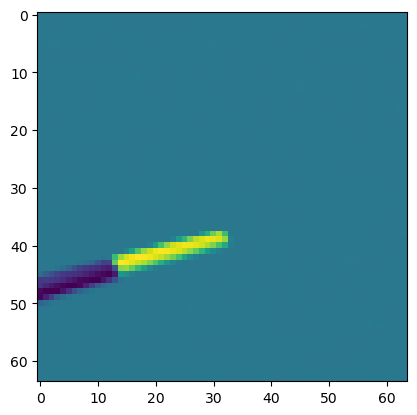

In [3]:
for batch in training_generator:
    break

plt.imshow(batch[0][0][0])
batch[1]

In [4]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [5]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*26*26, 6)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*26*26)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

torch.set_default_tensor_type(torch.FloatTensor)
model = Network()
no_of_params(model)

327594

In [7]:
lr = 1e-8
wd = 1e-3
model = Network()

epochs = 500
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )

gamma = 0.998
scheduler = lr_scheduler.ExponentialLR(
    optimizer, 
    gamma     = gamma)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,6), " Val loss: ",round(val_loss,6), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

EPOCH:  1  Train loss:  0.239045  Val loss:  0.22064  LR:  1e-08
EPOCH:  2  Train loss:  0.192622  Val loss:  0.173999  LR:  1e-08
EPOCH:  3  Train loss:  0.155934  Val loss:  0.150811  LR:  9.9e-09
EPOCH:  4  Train loss:  0.144629  Val loss:  0.142773  LR:  9.9e-09
EPOCH:  5  Train loss:  0.141655  Val loss:  0.144101  LR:  9.9e-09
EPOCH:  6  Train loss:  0.141651  Val loss:  0.144353  LR:  9.9e-09
EPOCH:  7  Train loss:  0.141001  Val loss:  0.143652  LR:  9.9e-09
EPOCH:  8  Train loss:  0.140041  Val loss:  0.143451  LR:  9.8e-09
EPOCH:  9  Train loss:  0.13911  Val loss:  0.143027  LR:  9.8e-09
EPOCH:  10  Train loss:  0.137443  Val loss:  0.140533  LR:  9.8e-09
EPOCH:  11  Train loss:  0.135648  Val loss:  0.140373  LR:  9.8e-09
EPOCH:  12  Train loss:  0.134821  Val loss:  0.138903  LR:  9.8e-09
EPOCH:  13  Train loss:  0.135023  Val loss:  0.139876  LR:  9.7e-09
EPOCH:  14  Train loss:  0.13549  Val loss:  0.139595  LR:  9.7e-09
EPOCH:  15  Train loss:  0.133521  Val loss:  0.13

EPOCH:  121  Train loss:  0.051288  Val loss:  0.060066  LR:  7.8e-09
EPOCH:  122  Train loss:  0.051127  Val loss:  0.059586  LR:  7.8e-09
EPOCH:  123  Train loss:  0.050909  Val loss:  0.060237  LR:  7.8e-09
EPOCH:  124  Train loss:  0.050783  Val loss:  0.060113  LR:  7.8e-09
EPOCH:  125  Train loss:  0.050526  Val loss:  0.059664  LR:  7.8e-09
EPOCH:  126  Train loss:  0.050403  Val loss:  0.058971  LR:  7.8e-09
EPOCH:  127  Train loss:  0.050181  Val loss:  0.058745  LR:  7.8e-09
EPOCH:  128  Train loss:  0.049979  Val loss:  0.058803  LR:  7.7e-09
EPOCH:  129  Train loss:  0.049719  Val loss:  0.058194  LR:  7.7e-09
EPOCH:  130  Train loss:  0.04948  Val loss:  0.058171  LR:  7.7e-09
EPOCH:  131  Train loss:  0.049329  Val loss:  0.057642  LR:  7.7e-09
EPOCH:  132  Train loss:  0.049173  Val loss:  0.057611  LR:  7.7e-09
EPOCH:  133  Train loss:  0.048936  Val loss:  0.057369  LR:  7.7e-09
EPOCH:  134  Train loss:  0.04879  Val loss:  0.057326  LR:  7.6e-09
EPOCH:  135  Train los

EPOCH:  239  Train loss:  0.041259  Val loss:  0.050293  LR:  6.2e-09
EPOCH:  240  Train loss:  0.041253  Val loss:  0.050232  LR:  6.2e-09
EPOCH:  241  Train loss:  0.041162  Val loss:  0.050224  LR:  6.2e-09
EPOCH:  242  Train loss:  0.041135  Val loss:  0.050517  LR:  6.2e-09
EPOCH:  243  Train loss:  0.04108  Val loss:  0.050119  LR:  6.1e-09
EPOCH:  244  Train loss:  0.041032  Val loss:  0.050603  LR:  6.1e-09
EPOCH:  245  Train loss:  0.040958  Val loss:  0.050301  LR:  6.1e-09
EPOCH:  246  Train loss:  0.040945  Val loss:  0.050365  LR:  6.1e-09
EPOCH:  247  Train loss:  0.04086  Val loss:  0.049758  LR:  6.1e-09
EPOCH:  248  Train loss:  0.040772  Val loss:  0.049791  LR:  6.1e-09
EPOCH:  249  Train loss:  0.040758  Val loss:  0.049909  LR:  6.1e-09
EPOCH:  250  Train loss:  0.040672  Val loss:  0.04959  LR:  6.1e-09
EPOCH:  251  Train loss:  0.040651  Val loss:  0.049559  LR:  6.1e-09
EPOCH:  252  Train loss:  0.040617  Val loss:  0.049717  LR:  6e-09
EPOCH:  253  Train loss: 

EPOCH:  357  Train loss:  0.037667  Val loss:  0.046981  LR:  4.9e-09
EPOCH:  358  Train loss:  0.037672  Val loss:  0.046715  LR:  4.9e-09
EPOCH:  359  Train loss:  0.037624  Val loss:  0.047025  LR:  4.9e-09
EPOCH:  360  Train loss:  0.037634  Val loss:  0.046839  LR:  4.9e-09
EPOCH:  361  Train loss:  0.037574  Val loss:  0.04704  LR:  4.9e-09
EPOCH:  362  Train loss:  0.037566  Val loss:  0.046944  LR:  4.8e-09
EPOCH:  363  Train loss:  0.037565  Val loss:  0.0467  LR:  4.8e-09
EPOCH:  364  Train loss:  0.037541  Val loss:  0.046864  LR:  4.8e-09
EPOCH:  365  Train loss:  0.037521  Val loss:  0.046889  LR:  4.8e-09
EPOCH:  366  Train loss:  0.037496  Val loss:  0.04663  LR:  4.8e-09
EPOCH:  367  Train loss:  0.037467  Val loss:  0.046365  LR:  4.8e-09
EPOCH:  368  Train loss:  0.037441  Val loss:  0.04659  LR:  4.8e-09
EPOCH:  369  Train loss:  0.037414  Val loss:  0.04695  LR:  4.8e-09
EPOCH:  370  Train loss:  0.037393  Val loss:  0.046594  LR:  4.8e-09
EPOCH:  371  Train loss:  

EPOCH:  475  Train loss:  0.035302  Val loss:  0.044227  LR:  3.9e-09
EPOCH:  476  Train loss:  0.035225  Val loss:  0.044508  LR:  3.9e-09
EPOCH:  477  Train loss:  0.035205  Val loss:  0.044358  LR:  3.8e-09
EPOCH:  478  Train loss:  0.035217  Val loss:  0.044486  LR:  3.8e-09
EPOCH:  479  Train loss:  0.035186  Val loss:  0.044738  LR:  3.8e-09
EPOCH:  480  Train loss:  0.035152  Val loss:  0.04494  LR:  3.8e-09
EPOCH:  481  Train loss:  0.03516  Val loss:  0.044361  LR:  3.8e-09
EPOCH:  482  Train loss:  0.035124  Val loss:  0.044603  LR:  3.8e-09
EPOCH:  483  Train loss:  0.03512  Val loss:  0.044689  LR:  3.8e-09
EPOCH:  484  Train loss:  0.035089  Val loss:  0.044295  LR:  3.8e-09
EPOCH:  485  Train loss:  0.035075  Val loss:  0.044671  LR:  3.8e-09
EPOCH:  486  Train loss:  0.035033  Val loss:  0.044202  LR:  3.8e-09
EPOCH:  487  Train loss:  0.035018  Val loss:  0.044242  LR:  3.8e-09
EPOCH:  488  Train loss:  0.035018  Val loss:  0.044376  LR:  3.8e-09
EPOCH:  489  Train loss

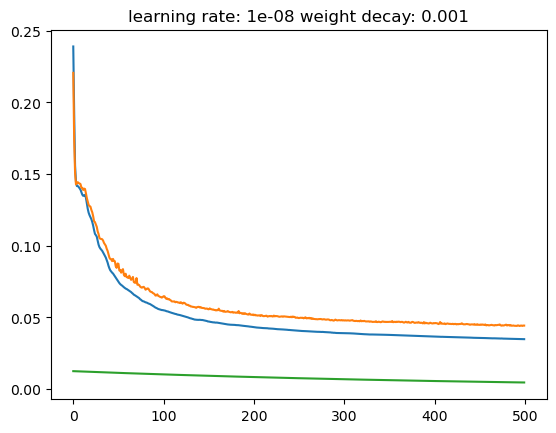

In [8]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

In [9]:
for batch in training_generator:
    break

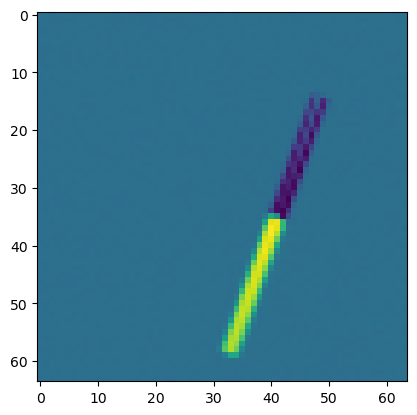

In [10]:
plt.imshow(batch[0][0][0])

In [14]:
import time

In [15]:
start = time.time()
output = model(batch[0])
end = time.time()

In [16]:
end - start

0.008976221084594727

In [12]:
batch[1][0]

tensor([-0.5932,  0.6193, -0.2527,  0.0345,  0.1222,  0.7371])

In [13]:
output[0]

tensor([-0.7210,  0.6218, -0.4653,  0.2115,  0.1972,  0.7062],
       grad_fn=<SelectBackward0>)